In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
#  from random import normal
#  from scipy.stats import bernoulli
import ipynb
from ipynb.fs.full.two_coin_v1 import sim_two_coin

In [2]:
# # parameters
# S0=30
# r=0.04
# t=6
# rate_drift = 0
# rate_volatility = 0.002
# vol=5 # volatility for stock price: for additive amount, how much to add
# drift = 0 # drift for stock price
# u=1+r+math.sqrt((1+r)**2-1) 
# d=(1+r)/u
# face=50
# coupon_rate = 0.04
# coupon = coupon_rate*face
# default_threshold = 1/3
# bankrupcy_ratio = 2.4
# K=55 # call at this value
# Pu=50 # put at this value

In [3]:
p=0.5#(1+r-d)/(u-d)
q=1-p
p=1-q # fixes floating-point errors hopefully
print(p, q) # only use these in the multiplicative model

0.5 0.5


In [4]:
def nSigFigs(num, n):
    #print(num == np.nan)
    if type(num) not in [float, int, np.float64] or num == float("NaN"): return float("NaN")
    return int(num * 10**n) / 10**n

In [5]:
def displayChart(tab):
    Chart=[]
    columns = []
    N = len(tab)-1
    for i in range(N, -1, -1):
        chart = []
        columns.append(N-i)
        for j in range(0,i):
            chart.append("")
        for j in range(i, N+1):
            entry = tab[j][i]
            chart.append(entry)
        Chart.append(chart)
    df = pd.DataFrame(Chart, columns = columns)
    return df.style.hide_index()

In [6]:
def r_values(t, r, rate_drift, rate_vol):
    R = {}
    for i in range(t, -1, -1):
        R[i] = r + i*rate_drift - rate_vol*np.arange(i, -1, -1) + rate_vol*np.arange(0, i+1, 1)
    return R

# rates = r_values(rate_drift, rate_volatility)
# print("interest rates")
# displayChart(rates)

In [7]:
# expected stock price (risk neutral pricing)
# additive model
def exp(x,y,p,r):
    if p != -1:
        return (x*p+y*(1-p))/(1+r)
    return 0

# # multiplicative model
# def rnExp(x,y, p=p,r=r):
#     return exp(x,y,p,r)

In [8]:
def StockPrice(S0, drift, vol): # for additive
    StockPrice={}
    for i in range(t, -1, -1):
        StockPrice[i] = np.maximum(np.zeros(i+1), S0 + i*drift - vol*np.arange(i, -1, -1) + vol*np.arange(0,i+1,1))
    '''for n in range(0, N+1):
        StockPrice[N].append(S0*(u**n)*(d**(N-n)))
    for i in range(N-1, -1, -1):
        StockPrice[i]=[] #np.empty(i+1)
        for j in range(0, i+1):
            StockPrice[i].append((StockPrice[i+1][j+1])/u)'''
    return StockPrice

def StockPrice_mul(vol): # for multiplicative
    StockPrice={}
    for i in range(t, -1, -1):
        StockPrice[i] = S0 * d ** (np.arange(i,-1,-1)) * u ** (np.arange(0,i+1,1)) #np.empty(N+1)
    return StockPrice

# SP = StockPrice(drift, vol)
# print("stock price")
# displayChart(SP)

# for i in range(t, -1, -1):
#     print(str(i) + ": "+str([nSigFigs(x, n=4) for x in SP[i]]))

In [9]:
def p_values(t, stock_price_chart, rates):
    P = {i: [1]*(i+1) for i in range(t+1)}
    for i in range(0, t):
        for j in range(i+1):
            if stock_price_chart[i][j] == 0:
                P[i][j] = -1
            else:
                d = stock_price_chart[i+1][j] / stock_price_chart[i][j]
                u = stock_price_chart[i+1][j+1] / stock_price_chart[i][j]
                P[i][j] = (1 + rates[i][j] - d) / (u-d)
                # print(d)
                # print(u)
                # print(u-d)
                # print(1+rates[i][j])
                # print(1 + rates[i][j] - d)
    return P

# p_vals = p_values(SP, rates)
# print("p tilde")
# displayChart(p_vals)

In [10]:
# expected stock price (risk neutral pricing)
# additive model
def exp(x,y,p,r):
    if p != -1:
        return (x*p+y*(1-p))/(1+r)
    return 0

# multiplicative model
def rnExp(x,y):
    return exp(x,y,p,r)

In [11]:
# bond_payoff = list(map(g, SP[t]))
def vanillaBond(t, payoff, rates, coupon, default_threshold, SP, p_vals): # coupon amount
    vanillaBond={}
    vanillaBond[t]=payoff
    # IP=IntrinsicPut()
    #for n in range(0, N+1):
    #    PutPriceA[N].append(IP[N][n])
    for i in range(t-1, -1, -1):
        vanillaBond[i]=[]
        for j in range(i+1):
            entry = [0,0]
            if SP[i][j] != 0: 
                entry[0] = exp(vanillaBond[i+1][j+1][0], vanillaBond[i+1][j][0], p_vals[i][j], rates[i][j]) + exp(vanillaBond[i+1][j+1][1], vanillaBond[i+1][j][1], p_vals[i][j], rates[i][j])
                entry[1] = coupon if (SP[i][j] >= default_threshold) and i>0 else 0
            #print(entry)
            vanillaBond[i].append(entry)
    return vanillaBond

# vBond = vanillaBond(bond_payoff, rates)
# print("Vanilla Bond payoff: [face value (after coupon), coupon]")
# displayChart(vBond)

In [12]:
def convBond(t, payoff, rates, coupon, default_threshold, SP, p_vals):
    convBond = {}
    convBond[t] = [[max(SP[t][i], payoff[i][0]), payoff[i][1]] for i in range(t+1)]
    for i in range(t-1, -1, -1):
        convBond[i]=[]
        for j in range(i+1):
            entry = [0,0]
            if SP[i][j] != 0: 
                entry[0] = exp(convBond[i+1][j+1][0], convBond[i+1][j][0], p_vals[i][j], rates[i][j]) \
                         + exp(convBond[i+1][j+1][1], convBond[i+1][j][1], p_vals[i][j], rates[i][j])
                entry[0] = max(entry[0], SP[i][j])
                entry[1] = coupon if SP[i][j] >= default_threshold else 0
            #print(entry)
            convBond[i].append(entry)
    convBond[0][0][1]=0
    return convBond

# cBond = convBond(bond_payoff, rates)
# print("Convertible Bond payoff: [face value (after coupon), coupon]")
# print("Convertible but not callable")
# displayChart(cBond)

In [13]:
def callable2(t, convertible, rates, coupon, default_threshold, SP, p_vals, K):
    callBond = {}
    callBond[t] = [[min(K, convertible[t][i][0]), convertible[t][i][1],0] for i in range(t+1)]
    for i in range(t+1):
        # 0 means not called, 1 means called
        callBond[t][i][2] = 1 if (K<=convertible[t][i][0]) else 0
    for i in range(t-1, -1, -1):
        callBond[i]=[]
        for j in range(i+1):
            entry = [0,0,0]
            if SP[i][j] != 0: 
                entry[0] = exp(callBond[i+1][j+1][0], callBond[i+1][j][0], p_vals[i][j], rates[i][j])
                entry[0] += exp(callBond[i+1][j+1][1], callBond[i+1][j][1], p_vals[i][j], rates[i][j])
                entry[2] = 1 if (K<entry[0]) else 0
                entry[0] = min(max(K, SP[i][j]), entry[0])
                entry[1] = coupon if ((SP[i][j] >= default_threshold) and i>0) else 0
            #print(entry)
            callBond[i].append(entry)
    return callBond

# callable_bond = callable2(cBond, rates)
# print("Callable Bond payoff: [face value (after coupon), coupon]")
# print("Convertible and callable")
# print("Conversion prioritized")
# displayChart(callable_bond)

In [14]:
def callable3(t, call_later, rates, coupon, default_threshold, SP, p_vals, K):
    callBond = {}
    callBond[t] = [[max(SP[t][i], call_later[t][i][0]), call_later[t][i][1],0] for i in range(t+1)]
    for i in range(t+1):
        # 0 means not called, 1 means called
        callBond[t][i][2] = 1 if (K<=call_later[t][i][0]) else 0
    for i in range(t-1, -1, -1):
        callBond[i]=[]
        for j in range(i+1):
            entry = [0,0,0]
            if SP[i][j] != 0: 
                entry[0] = exp(callBond[i+1][j+1][0], callBond[i+1][j][0], p_vals[i][j], rates[i][j])
                entry[0] += exp(callBond[i+1][j+1][1], callBond[i+1][j][1], p_vals[i][j], rates[i][j])
                entry[2] = 1 if (K<entry[0]) else 0
                entry[0] = max(SP[i][j], entry[0])
                entry[1] = coupon if ((SP[i][j] >= default_threshold) and i>0) else 0
            #print(entry)
            callBond[i].append(entry)
    return callBond

# call_second = callable3(callable_bond, rates)
# print("Callable Bond payoff: [face value (after coupon), coupon]")
# print("Convertible and callable")
# print("Call before convertion")
# displayChart(call_second)

In [15]:
def putable(t, convertible, rates, coupon, default_threshold, SP, p_vals, Pu):
    putBond = {}
    putBond[t] = [[convertible[t][i][0], convertible[t][i][1],0] for i in range(t+1)]
    for i in range(t+1):
        # 0 means not called, 1 means called
        putBond[t][i][2] = 1 if (K>=convertible[t][i][0]) else 0
    for i in range(t-1, -1, -1):
        putBond[i]=[]
        for j in range(i+1):
            entry = [0,0,0]
            if SP[i][j] != 0: 
                entry[0] = exp(putBond[i+1][j+1][0], putBond[i+1][j][0], p_vals[i][j], rates[i][j])
                entry[0] += exp(putBond[i+1][j+1][1], putBond[i+1][j][1], p_vals[i][j], rates[i][j])
                if(SP[i][j]==0):
                    # bankrupt
                    entry[0] = 0
                    entry[1] = 0
                    entry[2] = 0
                elif(0<SP[i][j]<=default_threshold):  
                    # financial distress
                    entry[0] = max(Pu/2, entry[0])
                    entry[1] = 1 if ((Pu/2)>entry[0]) else 0
                    entry[2] = 0 
                else:    
                    entry[2] = 1 if (Pu>entry[0]) else 0   
                    entry[0] = max(Pu, entry[0]) if (i<t) else entry[0]
                    entry[1] = coupon if (i>0) else 0
            #print(entry)
            putBond[i].append(entry)
    return putBond

# put_bond = putable(cBond, rates)
# print("Putabl Bond payoff: [face value (after coupon), coupon]")
# print("Convertible and putable")
# displayChart(put_bond)

In [16]:
# #conv_payoff: dictionary of convertible prices
# #strike: strike price
# def fill_payoff(payoff, time):
#     for i in range(time-1, -1, -1):
#         payoff[i] = []
#         for j in range(i+1):
#             entry = [0,0]
#             if SP[i][j] != 0: 
#                 entry[0] = exp(payoff[i+1][j+1][0], payoff[i+1][j][0], p_vals[i][j], rates[i][j]) + exp(payoff[i+1][j+1][1], payoff[i+1][j][1], p_vals[i][j], rates[i][j])
#                 entry[0] = entry[0]
#                 entry[1] = coupon if (SP[i][j] >= default_threshold) and i>0 else 0
#             payoff[i].append(entry)
#     return payoff
        
        
# def callable(conv, strike):
#     callable_prices = []
#     for i in range(t-1, -1, -1):    #i: time step
#         for j in range(i+1):        #j: # of nodes at time
#             if conv[i][j][0] >= strike:
#                 old_val = conv[i][j][0]
#                 conv[i][j][0] = strike
#                 #continue etc
#                 new_prices = {}
#                 new_prices[i] = []
#                 for k in range(i+1):
#                     entry = conv[i][k]
#                     new_prices[i].append(entry)
#                 #new_prices has one key i, and a list of length j
#                 new_prices = fill_payoff(new_prices, i)
#                 b_0 = new_prices[0][0][0]
#                 callable_prices.append(b_0)
#                 conv[i][j][0] = old_val
#     return callable_prices

# callable_prices_list = callable(cBond, K)
# print("The possible callable is prices are:")
# print(callable_prices_list)
# print("The minnimum callable bond price is:")
# print(min(callable_prices_list))

In [17]:
# parameters
S0=30
r=0.04
t=6
rate_drift = 0
rate_volatility = 0.002
vol=5 # volatility for stock price: for additive amount, how much to add
drift = 0 # drift for stock price
u=1+r+math.sqrt((1+r)**2-1) 
d=(1+r)/u
face=50
coupon_rate = 0.04
coupon = coupon_rate*face
default_threshold = 1/3
bankrupcy_ratio = 2.4
K=55 # call at this value
Pu=50 # put at this value

In [18]:
def g(x): # payoff function e.g for a call it would be max(0, x-K)
    if x==0:
        return [0, 0]
    if x <= default_threshold*S0:
        return [x*bankrupcy_ratio, 0]
    return [face, coupon] # first entry is the actual value, second is dividends or coupons

In [19]:
# x is how much to change for additive model
def simulate_single_random(x, interest_rates, rate_vol, rate_mode=1):
    volatility=x # volatility for stock price: for additive amount, how much to add

    if(rate_mode==0):
        rates = {}
        for key in range(0, t+1, 1):
            rates[key] = [0]*(key+1)
            for j in range(0, key+1, 1):
                rates[key][j] = np.random.normal(interest_rates[key][j], rate_vol)
    else:
        rates = interest_rates

    SP = StockPrice(S0, drift, volatility)
    # print("stock price")
    displayChart(SP)

    p_vals = p_values(t, SP, rates)
    # print("p tilde")
    # displayChart(p_vals)
    
    bond_payoff = list(map(g, SP[t]))

    vBond = vanillaBond(t, bond_payoff, rates, coupon, default_threshold, SP, p_vals)
    # print("Vanilla Bond payoff: [face value (after coupon), coupon]")
    # displayChart(vBond)

    cBond = convBond(t, bond_payoff, rates, coupon, default_threshold, SP, p_vals)
    # print("Convertible Bond payoff: [face value (after coupon), coupon]")
    # print("Convertible but not callable")
    # displayChart(cBond)

    callable_bond = callable2(t, cBond, rates, coupon, default_threshold, SP, p_vals, K)
    # print("Callable Bond payoff: [face value (after coupon), coupon]")
    # print("Convertible and callable")
    # print("Call after convertion")
    # displayChart(callable_bond)

    put_bond = putable(t, cBond, rates, coupon, default_threshold, SP, p_vals, Pu)
    # print("Putabl Bond payoff: [face value (after coupon), coupon]")
    # print("Convertible and putable")
    # displayChart(put_bond)

    put_price = put_bond[0][0]
    min_price = callable_bond[0][0]
    v_val = vBond[0][0]
    c_val = cBond[0][0]

    return [v_val[0], c_val[0], min_price[0], put_price[0]]

print("vanilla defaultable, basic convertible, convertible and callable, convertible and putable")
# displayChart(simulate_single(5))

vanilla defaultable, basic convertible, convertible and callable, convertible and putable


In [20]:
runs = 5 # number of simulations at each vol (how much to increase/decrease in the additive model)
lo = 4 # lowest vol
hi = 11 # highest vol
incr = -0.1 # negative

keys = np.arange(hi, lo, incr)
v_price = {}
c_price = {}
callable_price = {}
putable_price = {}

two_coin_vanilla = {}
two_coin_convertible = {}
two_coin_callable = {}
two_coin_putable = {}

rates = r_values(t, r, rate_drift, rate_volatility)

for i in keys: # try different vol 
    v_price[i] = ([0]*runs)
    c_price[i] = ([0]*runs)
    callable_price[i] = ([0]*runs)
    putable_price[i] = ([0]*runs)
    for j in range(0, runs, 1): 
        (v_price[i][j], c_price[i][j], callable_price[i][j], putable_price[i][j]) = simulate_single_random(i, rates,rate_volatility, 0)

    two_coin_vanilla[i] = [0]
    two_coin_convertible[i] = [0]
    two_coin_callable[i] = [0]
    two_coin_putable[i] = [0]
    (two_coin_vanilla[i][0], two_coin_convertible[i][0], two_coin_callable[i][0], two_coin_putable[i][0]) = simulate_single_random(i, rates, rate_volatility, 1)

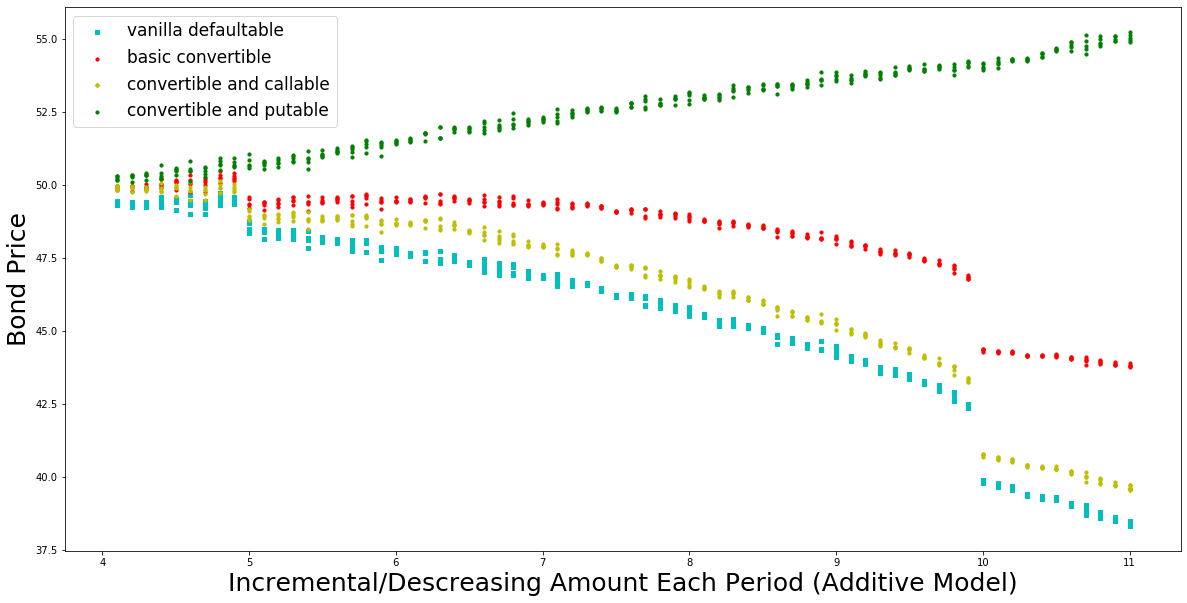

In [21]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot()
plt.xlabel('Incremental/Descreasing Amount Each Period (Additive Model)', fontsize = 25) 
plt.ylabel('Bond Price', fontsize = 25)               

for key in v_price:
    if(key == lo or key == hi):
        ax1.scatter([key]*runs, v_price[key], s=10, c='c', marker="s", label="vanilla defaultable")
        ax1.scatter([key]*runs, c_price[key], s=10, c='r', marker="o", label="basic convertible")
        ax1.scatter([key]*runs, callable_price[key], s=10, c='y', marker="D", label="convertible and callable")
        ax1.scatter([key]*runs, putable_price[key], s=10, c='g', marker="o", label="convertible and putable")
    else:
        ax1.scatter([key]*runs, v_price[key], s=10, c='c', marker="s")
        ax1.scatter([key]*runs, c_price[key], s=10, c='r', marker="o")
        ax1.scatter([key]*runs, callable_price[key], s=10, c='y')
        ax1.scatter([key]*runs, putable_price[key], s=10, c='g', marker="o")

plt.legend(loc='upper left', fontsize = 17)
plt.show() 

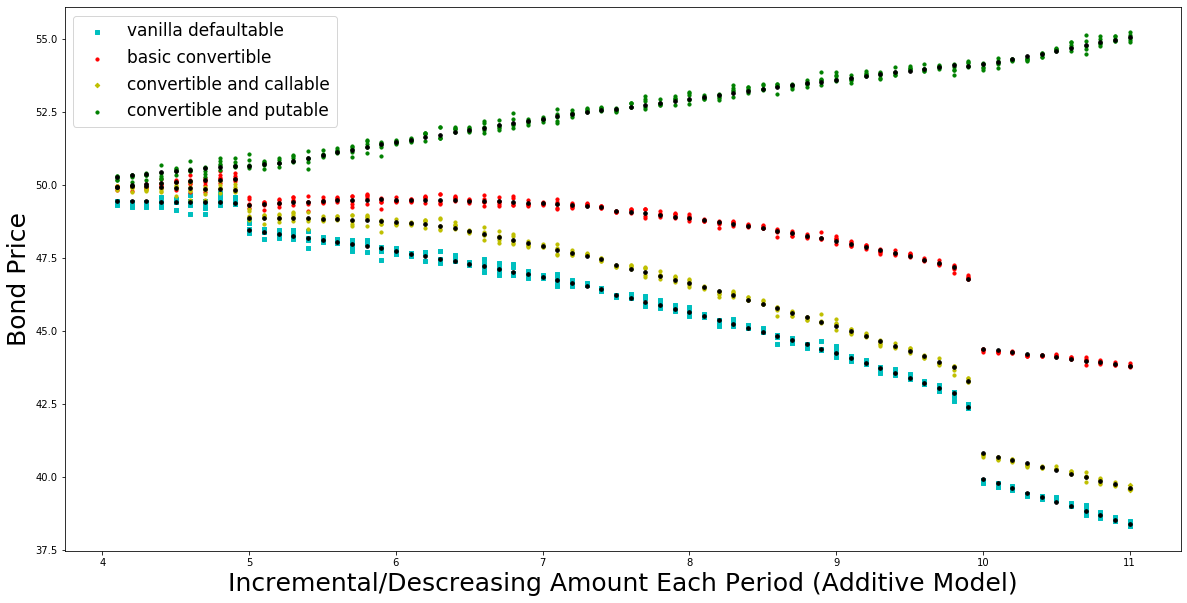

In [25]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot()
plt.xlabel('Incremental/Descreasing Amount Each Period (Additive Model)', fontsize = 25) 
plt.ylabel('Bond Price', fontsize = 25)               

for key in v_price:
    if(key == lo or key == hi):
        ax1.scatter([key]*runs, v_price[key], s=10, c='c', marker="s", label="vanilla defaultable")
        ax1.scatter([key]*runs, c_price[key], s=10, c='r', marker="o", label="basic convertible")
        ax1.scatter([key]*runs, callable_price[key], s=10, c='y', marker="D", label="convertible and callable")
        ax1.scatter([key]*runs, putable_price[key], s=10, c='g', marker="o", label="convertible and putable")
        ax1.scatter([key], two_coin_vanilla[key], s=13, c='k', marker="o")
        ax1.scatter([key], two_coin_convertible[key], s=13, c='k', marker="o")
        ax1.scatter([key], two_coin_callable[key], s=13, c='k', marker="o")
        ax1.scatter([key], two_coin_putable[key], s=13, c='k', marker="o")
    else:
        ax1.scatter([key]*runs, v_price[key], s=10, c='c', marker="s")
        ax1.scatter([key]*runs, c_price[key], s=10, c='r', marker="o")
        ax1.scatter([key]*runs, callable_price[key], s=10, c='y')
        ax1.scatter([key]*runs, putable_price[key], s=10, c='g', marker="o")
        ax1.scatter([key], two_coin_vanilla[key], s=13, c='k', marker="o")
        ax1.scatter([key], two_coin_convertible[key], s=13, c='k', marker="o")
        ax1.scatter([key], two_coin_callable[key], s=13, c='k', marker="o")
        ax1.scatter([key], two_coin_putable[key], s=13, c='k', marker="o")

plt.legend(loc='upper left', fontsize = 17)
plt.show() 